In [1]:
import os
import sys

os.chdir("../..")

# 1. Import necessary dependency

In [2]:
from lib.repository import get_mnist_data
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from lib.loss import *
from lib.activation import *
from lib.neural import *
from lib.ffnn import *
from lib.weight_initializer import *
from sklearn.neural_network import MLPClassifier



In [ ]:
print("Downloading MNIST data...")
mnist_data = get_mnist_data()
print(mnist_data)

Saved MNIST data to offline storage
{'X': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784)), 'y': array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object), 'metadata': {'dataset_name': 'mnist_784', 'version': 1, 'fetch_time': 3.3374032974243164}}


# 2. Comparison

In [4]:


X = mnist_data["X"]
y = mnist_data["y"]
X = X / 255.0  

# Convert string labels to integers if needed
y_int = np.array(y).astype(int) if isinstance(y[0], str) else np.array(y, dtype=int)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_int, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to one-hot encoding for custom neural network
num_classes = 10  # For MNIST
y_train_onehot = np.zeros((len(y_train), num_classes))
y_train_onehot[np.arange(len(y_train)), y_train] = 1

y_val_onehot = np.zeros((len(y_val), num_classes))
y_val_onehot[np.arange(len(y_val)), y_val] = 1

y_test_onehot = np.zeros((len(y_test), num_classes))
y_test_onehot[np.arange(len(y_test)), y_test] = 1

# Common parameters
architecture = [784, 128, 10]
learning_rate = 0.01
batch_size = 32
epochs = 5

# Function to evaluate models
def evaluate_model(model, X, y_onehot):
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_onehot, axis=1)
    return np.mean(predicted_classes == true_classes)


## FFNN from scratch

In [5]:
X_train_ffnn = X_train  # Add any specific preprocessing here if needed

# Create our custom FFNN
activations = [ReLU()] + [Softmax()]
network = NeuralNetwork(
    node_counts=architecture,
    activations=activations,
    loss_function=CCE(),
    initialize_methods=NormalInitializer(seed=42)
)
custom_model = FFNN(network)

# Train our custom model
print("Training custom FFNN model...")
custom_history = custom_model.fit(
    X_train_ffnn, y_train_onehot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val_onehot),
    learning_rate=learning_rate,
    verbose=1
)

# Evaluate custom model
custom_accuracy = evaluate_model(custom_model, X_test, y_test_onehot)
print(f"Custom FFNN accuracy: {custom_accuracy:.4f}")

Training custom FFNN model...


Epoch 1/5: 100%|██████████| 1532/1532 [00:05<00:00, 270.52it/s, loss=1.1154]


Epoch 1/5 - 5.76s - loss: 1.1154 - val_loss: 0.5521


Epoch 2/5: 100%|██████████| 1532/1532 [00:05<00:00, 289.89it/s, loss=0.4682]


Epoch 2/5 - 5.47s - loss: 0.4682 - val_loss: 0.4226


Epoch 3/5: 100%|██████████| 1532/1532 [00:04<00:00, 345.33it/s, loss=0.3776]


Epoch 3/5 - 4.51s - loss: 0.3776 - val_loss: 0.3736


Epoch 4/5: 100%|██████████| 1532/1532 [00:03<00:00, 431.82it/s, loss=0.3304]


Epoch 4/5 - 3.65s - loss: 0.3304 - val_loss: 0.3352


Epoch 5/5: 100%|██████████| 1532/1532 [00:04<00:00, 332.45it/s, loss=0.2987]


Epoch 5/5 - 4.69s - loss: 0.2987 - val_loss: 0.3096
Custom FFNN accuracy: 0.9130


## SKLearn

In [6]:



hidden_size = 128  
output_size = 10   
learning_rate = 0.01
batch_size = 32
epochs = 5

sklearn_model = MLPClassifier(
    hidden_layer_sizes=(hidden_size,),  
    activation='relu',                  
    solver='sgd',                       
    learning_rate_init=learning_rate,   
    alpha=0.0,
    batch_size=batch_size,              
    max_iter=epochs,                    
    random_state=42,                    
    verbose=True,
)

# Train sklearn model
print("Training sklearn MLPClassifier...")
print(f"Architecture: Input({input_size}) -> Hidden({hidden_size}) -> Output({output_size})")
print(f"Parameters: learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")

# Fit the model
sklearn_model.fit(X_train, y_train)

# Evaluate sklearn model
sklearn_predictions = sklearn_model.predict(X_test)
sklearn_accuracy = np.mean(sklearn_predictions == y_test)
print(f"\nsklearn MLP accuracy: {sklearn_accuracy:.4f}")



Training sklearn MLPClassifier...


NameError: name 'input_size' is not defined

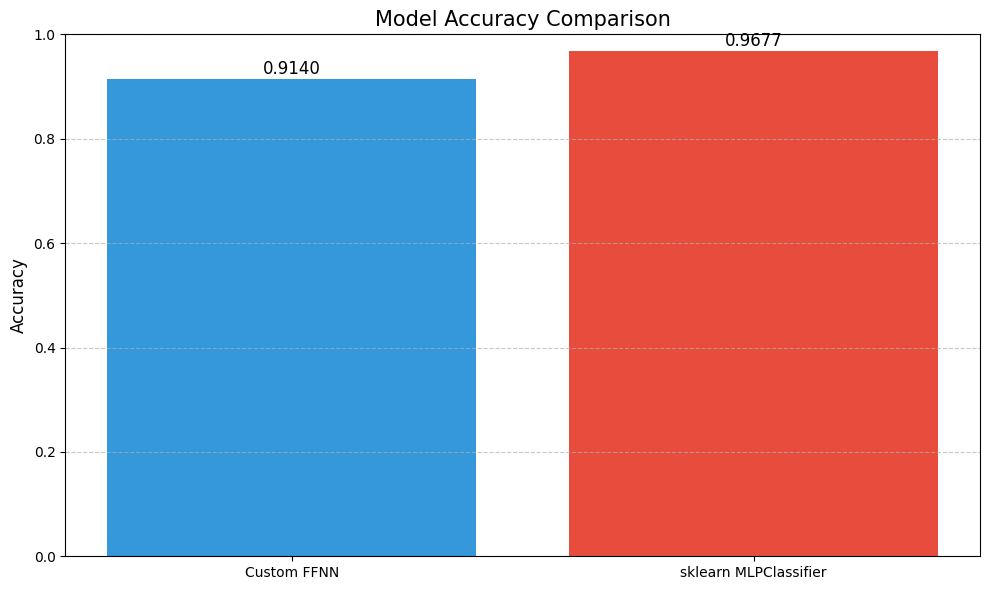

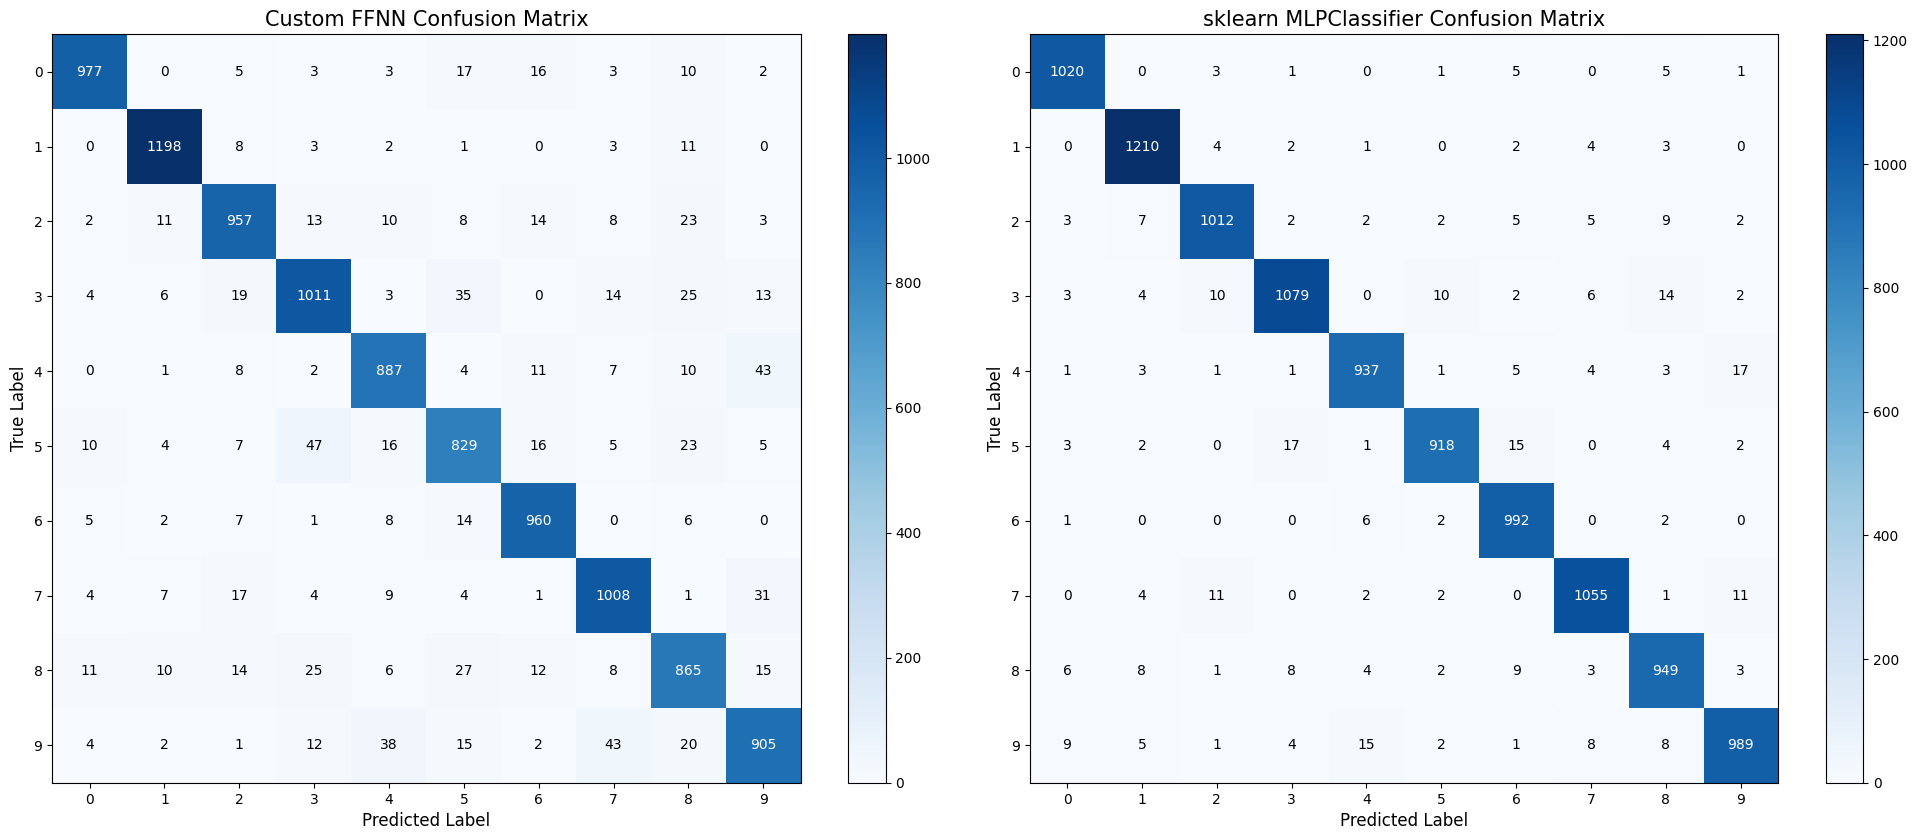

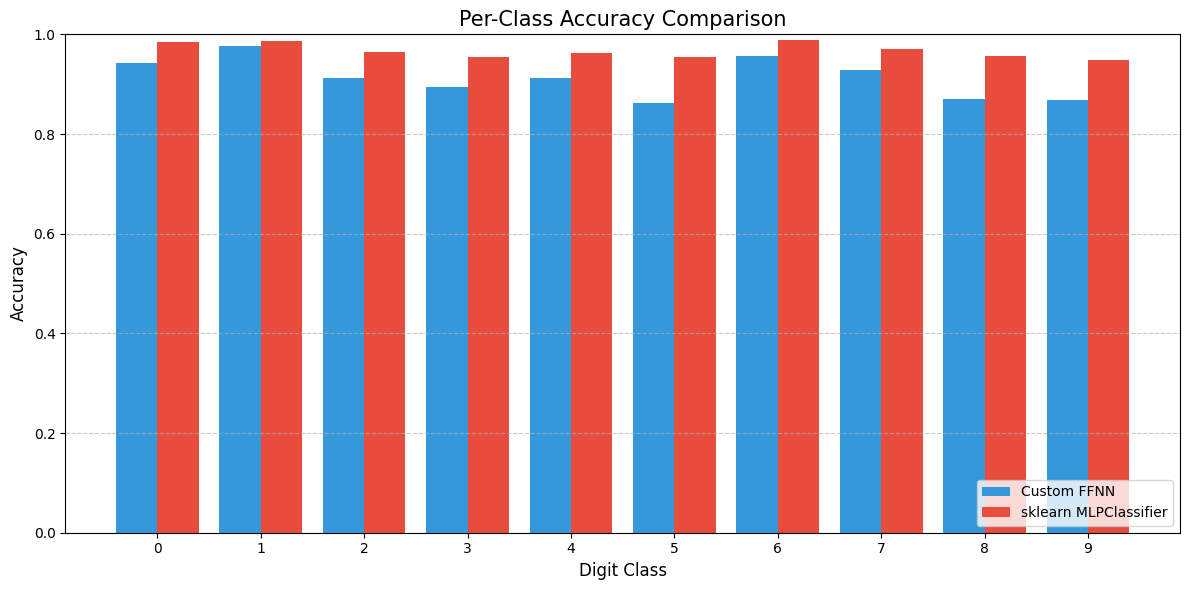

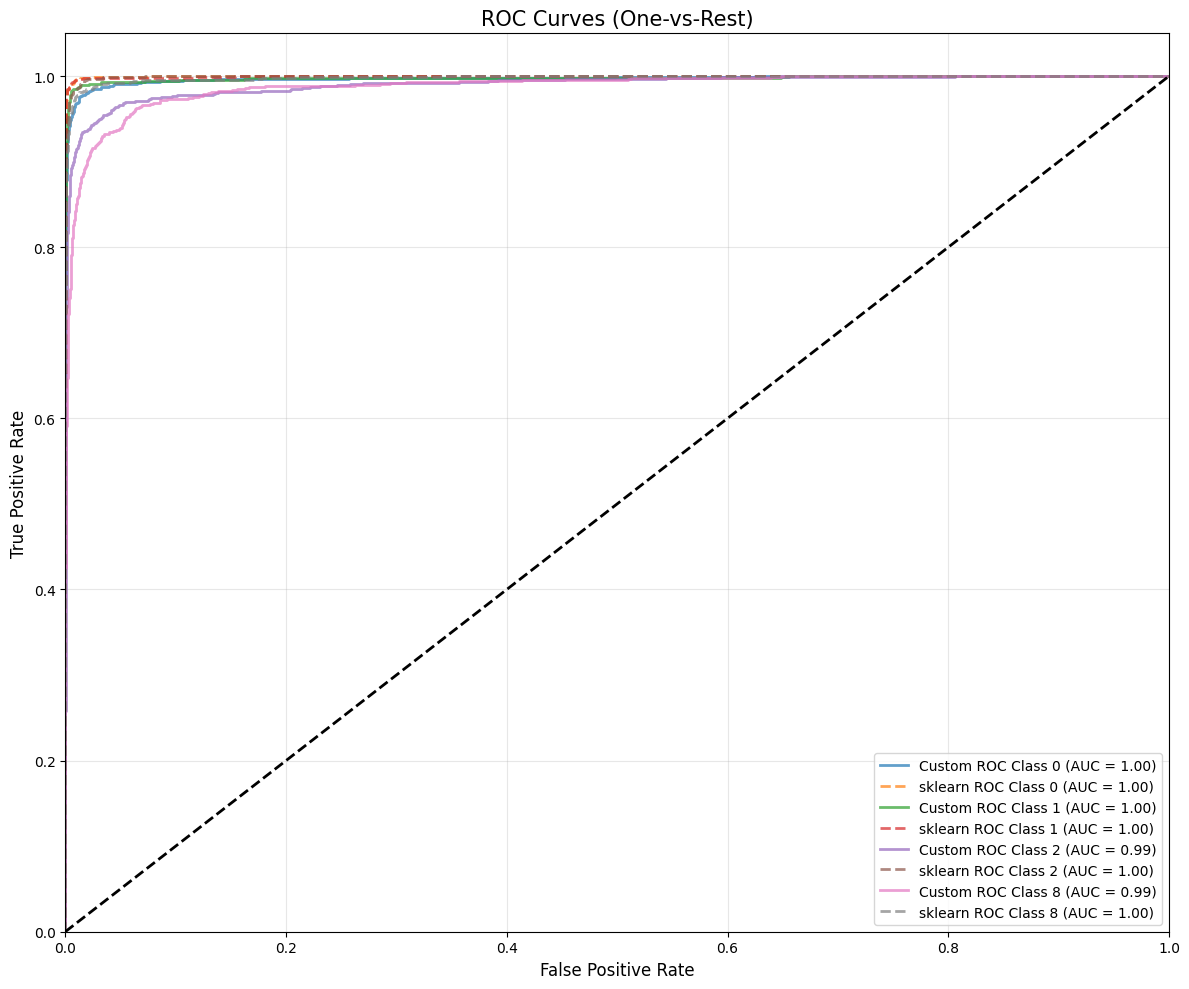

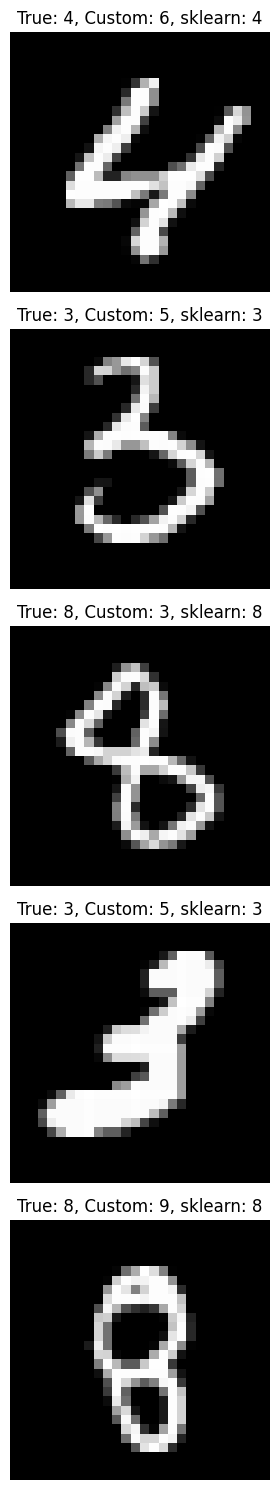


----- Model Comparison Summary -----
Metric                    Custom FFNN     sklearn MLP    
-------------------------------------------------------
Accuracy                  0.9140          0.9677         
Precision (macro)         0.9125          0.9676         
Recall (macro)            0.9125          0.9674         
F1 Score (macro)          0.9125          0.9674         
-------------------------------------------------------


In [ ]:
# Comprehensive comparison plots for custom FFNN vs sklearn MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Accuracy Comparison Bar Chart
plt.figure(figsize=(10, 6))
accuracies = [custom_accuracy, sklearn_accuracy]
plt.bar(['Custom FFNN', 'sklearn MLPClassifier'], accuracies, color=['#3498db', '#e74c3c'])
plt.title('Model Accuracy Comparison', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.0)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Custom FFNN Confusion Matrix
custom_predictions = np.argmax(custom_model.predict(X_test), axis=1)
custom_cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), custom_predictions)
im1 = axes[0].imshow(custom_cm, interpolation='nearest', cmap='Blues')
axes[0].set_title('Custom FFNN Confusion Matrix', fontsize=15)
fig.colorbar(im1, ax=axes[0])
axes[0].set_xticks(np.arange(10))
axes[0].set_yticks(np.arange(10))
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
for i in range(10):
    for j in range(10):
        text = axes[0].text(j, i, custom_cm[i, j],
                          ha="center", va="center", 
                          color="white" if custom_cm[i, j] > custom_cm.max()/2 else "black")

# sklearn MLPClassifier Confusion Matrix
sklearn_cm = confusion_matrix(y_test, sklearn_predictions)
im2 = axes[1].imshow(sklearn_cm, interpolation='nearest', cmap='Blues')
axes[1].set_title('sklearn MLPClassifier Confusion Matrix', fontsize=15)
fig.colorbar(im2, ax=axes[1])
axes[1].set_xticks(np.arange(10))
axes[1].set_yticks(np.arange(10))
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
for i in range(10):
    for j in range(10):
        text = axes[1].text(j, i, sklearn_cm[i, j],
                          ha="center", va="center",
                          color="white" if sklearn_cm[i, j] > sklearn_cm.max()/2 else "black")

plt.tight_layout()
plt.show()

# 3. Per-class accuracy comparison
custom_per_class = np.diag(custom_cm) / np.sum(custom_cm, axis=1)
sklearn_per_class = np.diag(sklearn_cm) / np.sum(sklearn_cm, axis=1)

plt.figure(figsize=(12, 6))
width = 0.4
x = np.arange(10)
plt.bar(x - width/2, custom_per_class, width, label='Custom FFNN', color='#3498db')
plt.bar(x + width/2, sklearn_per_class, width, label='sklearn MLPClassifier', color='#e74c3c')
plt.xlabel('Digit Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy Comparison', fontsize=15)
plt.xticks(x, [str(i) for i in range(10)])
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

# 4. ROC curves for each class (One-vs-Rest)
# Binarize the test labels for ROC curve calculation
y_test_bin = label_binarize(np.argmax(y_test_onehot, axis=1), classes=range(10))

# Get prediction probabilities
custom_probs = custom_model.predict(X_test)
sklearn_probs = sklearn_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(12, 10))

# Select classes to display to avoid overcrowding (e.g., 0, 1, 2, 8)
classes_to_show = [0, 1, 2, 8]

for i in classes_to_show:
    # Custom FFNN
    fpr_custom, tpr_custom, _ = roc_curve(y_test_bin[:, i], custom_probs[:, i])
    roc_auc_custom = auc(fpr_custom, tpr_custom)
    plt.plot(fpr_custom, tpr_custom, lw=2, alpha=0.7,
             label=f'Custom ROC Class {i} (AUC = {roc_auc_custom:.2f})')
    
    # sklearn MLP
    fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test_bin[:, i], sklearn_probs[:, i])
    roc_auc_sklearn = auc(fpr_sklearn, tpr_sklearn)
    plt.plot(fpr_sklearn, tpr_sklearn, lw=2, alpha=0.7, linestyle='--',
             label=f'sklearn ROC Class {i} (AUC = {roc_auc_sklearn:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves (One-vs-Rest)', fontsize=15)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Learning curves (if custom model history is available)
if hasattr(custom_history, 'history') and 'loss' in custom_history.history:
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation loss values for custom model
    plt.plot(custom_history.history['loss'], label='Custom Train Loss', linewidth=2)
    if 'val_loss' in custom_history.history:
        plt.plot(custom_history.history['val_loss'], label='Custom Validation Loss', linewidth=2)
        
    # Add loss values from sklearn model's loss curve if available
    if hasattr(sklearn_model, 'loss_curve_'):
        plt.plot(sklearn_model.loss_curve_, label='sklearn Loss', linewidth=2, linestyle='--')
    
    plt.title('Model Loss Curves', fontsize=15)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 6. Misclassification examples
# Find indices of examples where the models disagree
disagreement_indices = np.where(custom_predictions != sklearn_predictions)[0]

if len(disagreement_indices) > 0:
    # Select a few examples to display
    num_examples = min(5, len(disagreement_indices))
    selected_indices = disagreement_indices[:num_examples]
    
    plt.figure(figsize=(15, 3*num_examples))
    for i, idx in enumerate(selected_indices):
        true_label = np.argmax(y_test_onehot[idx])
        custom_pred = custom_predictions[idx]
        sklearn_pred = sklearn_predictions[idx]
        
        # Reshape image for display
        img = X_test[idx].reshape(28, 28)
        
        plt.subplot(num_examples, 1, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {true_label}, Custom: {custom_pred}, sklearn: {sklearn_pred}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 7. Summary statistics table
print("\n----- Model Comparison Summary -----")
print(f"{'Metric':<25} {'Custom FFNN':<15} {'sklearn MLP':<15}")
print("-" * 55)
print(f"{'Accuracy':<25} {custom_accuracy:<15.4f} {sklearn_accuracy:<15.4f}")

# Calculate other metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# For custom model
custom_precision = precision_score(np.argmax(y_test_onehot, axis=1), custom_predictions, average='macro')
custom_recall = recall_score(np.argmax(y_test_onehot, axis=1), custom_predictions, average='macro')
custom_f1 = f1_score(np.argmax(y_test_onehot, axis=1), custom_predictions, average='macro')

# For sklearn model
sklearn_precision = precision_score(y_test, sklearn_predictions, average='macro')
sklearn_recall = recall_score(y_test, sklearn_predictions, average='macro')
sklearn_f1 = f1_score(y_test, sklearn_predictions, average='macro')

print(f"{'Precision (macro)':<25} {custom_precision:<15.4f} {sklearn_precision:<15.4f}")
print(f"{'Recall (macro)':<25} {custom_recall:<15.4f} {sklearn_recall:<15.4f}")
print(f"{'F1 Score (macro)':<25} {custom_f1:<15.4f} {sklearn_f1:<15.4f}")
print("-" * 55)